# **Mini Project-3**

This is the main python file for Mini Project-3 of ECSE-551: Machine Learning for Engineers
- In this code, the Image Classification is performed on the MNIST+Fasion MNIST data set of 60k using the LeNet, VGG, and ResNet CNN, and later the the Ensembling in the form of the majority voting is done. 
- At the last, in Kaggle the test accuracy on the 30% Test data set was found to be 97.533 %.  

Project made by:     
1. Aishwarya Ramamurthy (ID: 260963956)
2. Alok Patel (ID: 260954024)
3. Katyayani Prakash (ID: 260964511)


# **ReadMe:**

Note: Look at each cell for more instruction

1) First, load the _Train.pkl_ , _Train_labels.csv_ , and _Test.pkl_ files which will be used for the training and testing pupose of various algorithms using the drive.

---
2) At the start, code of the pre-processing of the data and the data is loaded  into the dataloader for the training and the testing of the data. 

---
3) Then the following cells are the cells which performs the data augmentation, in the form of the Image resize and the Image Rotation.

---
4) LeNet, VGG, and ResNet CNN are defined and created.

---
5) Later cells contribute for the training, validation and testing of all the models.

---
6) Lastly, the test results are stored in the csv file to make it ready for the kaggle, and then the ENSEMBLE method is done using the majority of voting.

---

**Preprocessing of the data and its Analysis**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Folder of the  drive is accessed
%cd '/content/gdrive/MyDrive/MP3_data'

/content/gdrive/MyDrive/MP3_data


**Calling all IMP Libraries**

In [ ]:
## --- Calling all the Neccessary Libraries --- ##
import torch    
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
from tqdm.notebook import tqdm_notebook
import random

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2

#print(torch.__version__)

**Extra Data Loading for the data observation**

In [ ]:
## ---- Not needed --- ##
# Data directly loaded using the drive as a mount 
#If we don't want to use we will not use.
import numpy as np

#train_data_1 = np.load('/content/gdrive/MyDrive/ECSE_551/Assignment-3/train/Train.pkl', allow_pickle=True).reshape(-1, 28, 28)

train_data_1 = np.load('/content/gdrive/MyDrive/ECSE-551/imageunderstanding/Train.pkl', allow_pickle=True).reshape(-1, 28, 28)

In [ ]:
#Checking the size of the data and checking the array of one image
import random
#print(train_data_1.shape)     #To print the shape of the dataset

#This data is already been given normalized in the training data file.
a = random.randint(0, 59999)
print("The image index id is: "+str(a))
train_data_1[a]
print(train_data_1[a].shape)
#255*train_data[a]        #To check the not normalized pixel data array.

#To display the random image from the set
import matplotlib.pyplot as plt
plt.imshow(train_data_1[a], cmap="binary")

The image index id is: 48186
Shape of training data =  (60000, 28, 28)


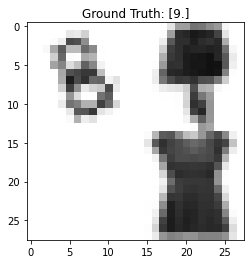

In [ ]:
# Loading the data here using the pickle library
# Read a pickle file and disply its samples
# Note that image data are stored as unit8 so each element is an integer value between 0 and 255
a = random.randint(0, 59999)
data = pickle.load( open( './Train.pkl', 'rb' ), encoding='bytes').reshape(-1,28,28)    #Reshape from (1,28,28) to (28,28), if RGB then 3 instead of 1 in image shape
targets = np.genfromtxt('./Train_labels.csv', delimiter=',', skip_header=1)[:,1:]       #skip_header = 1, will remove the 1st unwanted row of the label file and [:,1:] will remove the 1st column
plt.imshow(data[1236],cmap='binary', vmin=0, vmax=1)                                    #As normalized images are given we have taken the vmax=1, otherwise we have 255
plt.title("Ground Truth: {}".format(targets[a]))
print("The image index id is: "+str(a))

print("Shape of training data = ",data.shape)
#print(targets)                                                                  #To see the matrix of the targets stored

In [ ]:
import random

#This data is already been given normalized in the training data file.
a = random.randint(0, 59999)
print("The image index id is: "+str(a))
train_data_1[a]
#255*train_data[a]        #To check the not normalized pixel data array.

#To display the random image from the set
import matplotlib.pyplot as plt
plt.imshow(train_data_1[a], cmap="binary")
plt.title("Ground Truth: {}".format(targets[a]))

**Dataset and Dataloader class for the training of the CNN**

Transformation of the Data

In [ ]:
# Code for the image resize and rotation
size = (224,224)
img_resize = transforms.Resize(size)
img_rotation = transforms.RandomAffine(degrees=30)
#img_transform = transforms.Compose([img_resize, transforms.ToTensor()])
img_transform = transforms.Compose([ img_rotation, transforms.ToTensor()])

MyDataset Class for creating the dataset for the CNN

In [ ]:
# Dataset class and Dataloader class
from skimage.util import img_as_ubyte

class MyDataset(Dataset):
  def __init__(self, img_file, label_file, transform=None, idx = None):
    self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')                     
    self.targets = np.genfromtxt(label_file, delimiter=',', skip_header=1)[:,1:]           #When the labels file will be loaded the 1st row will be removed.
    self.transform = transform
    
    if idx is not None:
      self.targets = self.targets[idx]
      self.data = self.data[idx]

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, index):
    img, target = self.data[index], int(self.targets[index])

    if self.transform is not None: 
      img = img.reshape(28,28)
      #print(img.shape)
      img = Image.fromarray(img.astype('float'), mode='1')                      #float is for 0 to 1 image type and mode = 1 is for 0 to 1 same
      #img_as_ubyte(img)
      #plt.imshow(imgs[3],cmap='binary', vmin=0, vmax=1) 
      img = self.transform(img)
      #img = img.reshape(1,224,244)

    return img, target

Main Cell for creating the Dataloader for the training data

In [ ]:
## ---- Main Data loader for whole training set ---- ##
# Read image data and their label into a Dataset class #

## Note:- Taking the test data of around 1000 from this 60000 set as well. 

dataset = MyDataset('./Train.pkl', './Train_labels.csv', idx=None)

#Loading data using DataLoader
batch_size = 1000                                                               #We decide it according to the size for the training or test data
train_data = DataLoader(dataset, batch_size=batch_size, shuffle=True)           #Shuffle=False if we want to fix the arrangement of data

**Loading the Test data set for Kaggle**

In [ ]:
# Test data using dataloader 
# Used for ResNet
img_file = './Test.pkl'
batch_size = 1000
data = pickle.load( open( img_file, 'rb' ), encoding='bytes')   
test_data = DataLoader(data, batch_size = batch_size)

Dataloader for the change in image size (Not working)

In [ ]:
# Image size change
dataset = MyDataset('./Train.pkl', './Train_labels.csv', transform = img_transform, idx=None)

#Loading data using DataLoader
batch_size = 1000           #We decide it according to the size for the training or test data
train_data = DataLoader(dataset, batch_size=batch_size, shuffle=True)   #Shuffle=False if we want to fix the arrangement of data

#print(train_data)
imgs, labels = (next(iter(train_data)))

In [ ]:
imgs = np.squeeze(imgs)
print(imgs[3][150])
plt.imshow(imgs[3].cpu().numpy(),cmap='gray', vmin=0, vmax=1) #.transpose()
#plt.imshow(imgs[12].reshape(224,224),cmap='binary') 

In [ ]:
#Seeing rotating image
plt.imshow(imgs[60].reshape(28, 28).cpu().numpy(),cmap='binary', vmin=0, vmax=1)

In [ ]:
# Image Rotation added

dataset = MyDataset('./Train.pkl', './Train_labels.csv', img_transform, idx=None)

#Loading data using DataLoader
batch_size = 1000           #We decide it according to the size for the training or test data
train_data = DataLoader(dataset, batch_size=batch_size, shuffle=True)   #Shuffle=False if we want to fix the arrangement of data

imgs, labels = (next(iter(train_data)))

**Dataset Making for VGG by 1x28x28 to 1x224x224**

In [ ]:
## ---- Loading the training data for the VGG ----- ##
import pandas as pd

data_vgg = pickle.load( open('./Train.pkl', 'rb' ), encoding='bytes').reshape(-1,28,28)
data_train_vgg = torch.tensor(data_vgg, dtype=torch.float32)
df = pd.read_csv(r'./Train_labels.csv')
cls = df['class']
label_vgg = np.array(cls) 

In [ ]:
## ------ Function fot the batches of the dataset for VGG ------ ##

def vgg_data(data_vgg, ran):
  res_img = []
  resize_images = np.zeros([10000,224,224])
  for a in range(len(ran)):
    original_img = data_vgg[ran[a]]
    rsz = cv2.resize(original_img,(224,224))
    res_img.append(rsz)
    resize_images[a] = np.array(res_img[a])

    return resize_images

In [ ]:
## ------ Create batches of the dataset for vgg ------ ##

lst  = list(range(0,60000,1))
batch = 10000           #Each split of 10000 (Batch size)
spl = [lst[i:i + batch] for i in range(0, len(lst), batch)]

b1_vgg = vgg_data(data_train_vgg, spl[0])

vgg_b1_labels = label_vgg[:10000]
b1_vgg = b1_vgg.reshape(10000,1,224,224)
b1_vgg = b1_vgg.astype('float32')

In [ ]:
## ---- Updating the dataloader for vgg (10k) ---- ##
batch_size = 50
vgg_data = DataLoader(b1_vgg, batch_size = batch_size, shuffle = True)

Size of resize_imgages (1000, 224, 224)


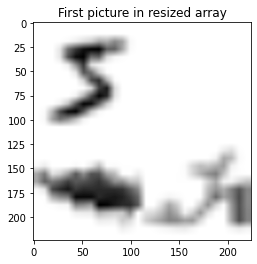

In [ ]:
# ---- For the manual images resize ---- ##

resize_images = np.zeros([1000,224,224])
#res_img = np.reshape(res_img,(2,3))

res_img = []

for a in range(1000):
  #print(a)
  #plt.imshow(data[a],cmap='binary', vmin=0, vmax=1)
  #plt.title("Ground Truth: {}".format(targets[a]))
  #plt.show()
  #print("Size of image =",data[a].shape)
  original_img = data[a]
  rsz = cv2.resize(original_img,(224,224))
  #plt.imshow(rsz,cmap='binary', vmin=0, vmax=1)
  #plt.show()
  #print("Size of new image =",rsz.shape)
  res_img.append(rsz)
  resize_images[a] = np.array(res_img[a])
  #print(res_img[a])


#resize_imgages = np.array(res_img[0])
print("Size of resize_imgages",resize_images.shape)
plt.imshow(resize_images[0],cmap='binary')
plt.title('First picture in resized array')
plt.show()

In [ ]:
# Loading the training data for the VGG 
data_train_vgg = pickle.load( open('./Train.pkl', 'rb' ), encoding='bytes').reshape(-1,28,28)   

In [ ]:
# Function for the resizing of the 60 ths data [Extra][Not Needed]

def resize(data, st, en):
  resize_img = np.zeros([en-st,224,224])
  res_img = []
  for a in range(st, en):
    original_img = data[a]
    rsz = cv2.resize(original_img,(224,224))
    res_img.append(rsz)
    resize_img[a] = np.array(res_img[a])

  return resize_img

In [ ]:
# Converting the image size from 28x28 to 224x224

lst  = list(range(0,60000,1))
batch = 600           #Each split of 600 (Batch size)
split = [lst[i:i + batch] for i in range(0, len(lst), batch)]

d1 = 224 
d3 = 1
lst2 = [[ ['#' for col in range(d1)] for col in range(d1)] for row in range(d3)]
final_array = np.array(lst2)        #1st element just sample later removed

#final_array = torch.from_numpy(final_array)
for i in range(len(split)):
#for i in range(1):
  resize_op = resize(data_train_vgg, split[i][0], (split[i][-1])+1)     #+1 as in range last is not count
  #final_array.append(resize_op)
  #tens = torch.from_numpy(resize_op)
  #torch.cat((final_array, tens), 0)
  final_array = np.concatenate((final_array, resize_op), axis = 0)
  
#Final_resize = np.array(final_array)
print(final_array, final_array.shape)
print("Size of final resize_images",Final_resize.shape)

In [ ]:
#Converting the resized array to a tensor
VGG_Train = torch.tensor(resize_images, dtype=torch.float32, device='cuda')
print("VGG Train image tensor size = ",VGG_Train.shape)

VGG Train image tensor size =  torch.Size([1000, 224, 224])


**Code Snippet for Rotating images [IMP for the Data Augmentation]**


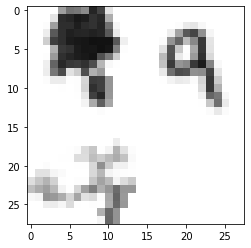

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3891: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


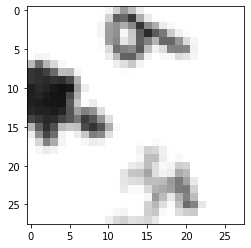

Rotated imgs size= torch.Size([10000, 1, 28, 28])


In [ ]:
## --- Image Rotation Functions for the randome 10000 images --- ##

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv(r'./Train_labels.csv')
cls = df['class']
label_rotation = np.array(cls)

#Loading the 10000 images(first whole data and then pick selected) 
data_rotation = np.load('./Train.pkl', allow_pickle=True)
#label_rotation = np.genfromtxt('./Train_labels.csv', delimiter=',', skip_header=1)[:,1:]

image_index = np.random.randint(0,60000,size=10000)             #Chossing random 10 ths images 

#Taking the 10000 images and its index randomly from 60 ths set.
rotation = data_rotation[image_index] 
image_rot_label = label_rotation[image_index]
img_to_rotate = torch.tensor(rotation)                          #Tensor, as required by rotation fun
#image_rot_label = torch.tensor(image_rot_label)
img_to_rotate = img_to_rotate.cuda()
#image_rot_label = image_rot_label.cuda()
#img_to_rotate.device

# Funtion that do the rotation of the images
def get_rot_mat(theta):
    theta = torch.tensor(theta)
    return torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                         [torch.sin(theta), torch.cos(theta), 0]])

def rot_img(x, theta, dtype):
    rot_mat = get_rot_mat(theta)[None, ...].type(dtype).repeat(x.shape[0],1,1)
    grid = F.affine_grid(rot_mat, x.size()).type(dtype)
    x = F.grid_sample(x, grid)
    return x

#dtype =  torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
dtype = torch.cuda.FloatTensor

#im should be a 4D tensor of shape B x C x H x W with type dtype, range [0,255]:
see_img = np.squeeze(img_to_rotate)
plt.imshow(see_img[1].reshape(28, 28).cpu().numpy(),cmap='binary', vmin=0, vmax=1)
#plt.imshow(imgs[0],cmap='binary',vmin=0,vmax=1) #To plot it im should be 1 x C x H x W
plt.show()

#Rotation by np.pi/6 with autograd support:
rotated_im_data = rot_img(img_to_rotate, np.pi/4, dtype)     # Rotate image by 30 degrees.

#Plot rotated images
see_img1 = np.squeeze(rotated_im_data)
plt.imshow(see_img1[1].reshape(28, 28).cpu().numpy(),cmap='binary', vmin=0, vmax=1)
plt.show()
print("Rotated imgs size=",rotated_im_data.shape)

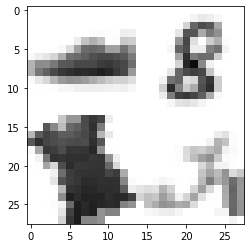

In [ ]:
## ----- EXTRA ----- ##
# Read image data and their label into a Dataset class
# Test and train data is uploaded from this cell.

## Note:- Taking the test data of around 6000 from this 60000 set as well. 

dataset = MyDataset('./Train.pkl', './Train_labels.csv', idx=None)

#Loading data using DataLoader
batch_size = 1000                                                               #We decide it according to the size for the training or test data
train_data = DataLoader(dataset, batch_size=batch_size, shuffle=True)           #Shuffle=False if we want to fix the arrangement of data

#Read a batch of data and their labels and display them
imgs, labels = (next(iter(train_data)))                                         #Calling methods (same like for loop)
see_img = np.squeeze(imgs)
plt.imshow(see_img[1].reshape(28, 28).cpu().numpy(),cmap='binary', vmin=0, vmax=1)

Below four cells are extra


In [ ]:
# Loading the test.pkl using the array and loading in the tensor
# Used for LeNet 

data_test = np.load('./Test.pkl', allow_pickle=True)
test_data = torch.tensor(data_test, dtype=torch.float32, device='cuda')
#test_data = DataLoader(data_test, batch_size=batch_size, shuffle=False)

In [ ]:
# Shape when dataloader is used.
print(imgs.shape)
print(labels.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000])


In [ ]:
## --- NEW when data is converted to the tensor [Extra] --- ##

#train_img = train_img.astype(np.float32)
#label_img = label_img.astype(np.float32)
train_img = torch.tensor(dataset.data, dtype=torch.float32, device='cuda')
label_img = torch.tensor(dataset.targets, dtype=torch.long, device ='cuda').reshape(-1,)

#print(dataset.data)
print("Train image dataset size = ",train_img.shape)
print("Train label dataset size = ",label_img.shape)

Train image dataset size =  torch.Size([60000, 1, 28, 28])
Train label dataset size =  torch.Size([60000])


In [ ]:
print(img.shape)

torch.Size([6000, 1, 28, 28])


**LeNet - CNN**

In [ ]:
## Class of LeNet CNN model for MNIST+Fashion-MNIST Dataset ##

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    
    #First Convolutional Layer which converts (28x28)x1 to (24x24)x6
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5)    
    
    #Max pooling of 2x2, which makes next layer dim as (12x12)x6
    #It is also used after 2nd Conv layer which makes next layer dim as (4x4)x16
    self.pool = nn.MaxPool2d(2,2)
    
    #Second Convolutional Layer which converts (12x12)x6 to (8x8)x16
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    
    #NN at the FC region 
    self.fc1 = nn.Linear(16*4*4,120)      #1st FC layer
    self.fc2 = nn.Linear(120,84)          #2nd FC layer
    self.fc3 = nn.Linear(84,10)           #Output layer

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1,16*4*4)                 #Matrix to vector conversion of Conv to NN(FC) i/p
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)                       #output layer executed

    return x
    #return F.log_softmax(x, dim=1)
 
#Below Function is for testing
'''
  def forward(self,x):
    x = F.sigmoid(self.pool(F.tanh(self.conv1(x))))        #For testing purpose
    x = F.sigmoid(self.pool(F.tanh(self.conv1(x))))               #For testing purpose
    x = x.view(-1,16*4*4)                
    x = F.tanh(self.fc1(x))
    x = F.tanh(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x)
'''
print()

**VGG - CNN**

In [ ]:
# Class of VGG CNN model for MNIST+Fasion-MNIST Dataset
import torchvision.models as models

#class VGG(): 

device = 'cuda'
vgg = models.vgg16(pretrained = False, progress=True)                           #Pretrained is OFF and Progress bar is made ON
vgg.features[0] = nn.Conv2d(1, 64,3,1)
vgg.classifier[-1] = nn.Linear(4096,1000)
vgg.classifier.add_module('7', nn.ReLU())
#vgg.classifier.add_module('8', nn.Dropout(p=0.5, inplace=False))
vgg.classifier.add_module('8', nn.Linear(1000, 10))
vgg.classifier.add_module('9', nn.LogSoftmax(dim=1))

vgg.to(device)


In [ ]:
#Good to Know the architecture
print(vgg) 

**ResNet - CNN**

In [ ]:
# ---- ResNet 18 ----- #
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck

class MFResNet(ResNet):
    def __init__(self):
        super(MFResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10) # Based on ResNet18
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3,bias=False)


In [ ]:
# ---- ResNet 34 ----- #
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck

class MFResNet(ResNet):
    def __init__(self):
      super(MFResNet, self).__init__(BasicBlock, [3, 4, 6, 3], num_classes=10)
      self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3,bias=False)


**Training and Testing on ResNet**

In [ ]:
# --- ResNet and its optimizer --- #
resnet = MFResNet()

optimizer = optim.Adam(resnet.parameters(), lr = 0.001)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
## ---- Adding the dropout features for Resnet ---- ##

num_ft = resnet.fc.in_features
resnet.fc = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(num_ft, 10))
resnet = resnet.to('cuda')

In [ ]:
print(resnet)

In [ ]:
## ---- Getting data ready for the rotated images ---- ##
rotated_data = rotated_im_data.cpu().numpy()
batch_size = 1000
train_rot_data = DataLoader(rotated_data, batch_size = batch_size, shuffle = False)

In [ ]:
# --- Training of the rotated + originial dataset on ResNet --- #
import time
from tqdm.notebook import tqdm_notebook

lst  = list(range(0,10000,1))
batch = 1000
split = [lst[i:i + batch] for i in range(0, len(lst), batch)]

test_counter = [i*len(train_data.dataset) for i in range(3)]
best_acc = 0
avg_acc = 0

iterations = 5        #Setting no. of epochs
progress_bar = tqdm_notebook(iterable=range(iterations), position=0, leave=True)

start = time.time()
for epoch in progress_bar:
  resnet.train()
  correct1 = 0
  total1 = 0
  correct2 = 0
  total2 = 0
  for batch_idx, (data, target) in enumerate(train_data):
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output1 = resnet(data).cuda()
    _, predicted = torch.max(output1, 1)
    correct1 += (predicted == target).sum().item()
    loss1 = criterion(output1, target)             
    total1 += target.size(0)
    acc1 = (correct1 / total1) * 100.0
    progress_bar.set_description(f"Loss : {loss1.item():.3f}, Main Data Accuracy : {acc1:.3f}")
    loss1.backward()
    optimizer.step()

  print(f'Epoch : {epoch+1} ; Training Accuracy on main data: {acc1:.3f}')

  var = 0
  for _, dat in enumerate(train_rot_data):          #As 10 data will be so 10 times loops
    tar = image_rot_label[split[var]]
    tar = torch.tensor(tar)
    dat, tar = dat.cuda(), tar.cuda()
    optimizer.zero_grad()
    output2 = resnet(dat).cuda()
    _, pred = torch.max(output2, 1)
    correct2 += (pred == tar).sum().item()
    loss2 = criterion(output2, tar)             
    total2 += tar.size(0)
    acc2 = (correct2 / total2) * 100.0
    progress_bar.set_description(f"Loss : {loss2.item():.3f}, Rotated data Accuracy : {acc2:.3f}")
    loss2.backward()
    optimizer.step()
    var = var + 1

  print(f'Epoch : {epoch+1} ; Training Accuracy on rotated data: {acc2:.3f}')
  avg_acc = (acc1+acc2)/2

  if avg_acc>best_acc:
    best_acc = avg_acc
    torch.save(resnet.state_dict(), '/model.pth')
    torch.save(optimizer.state_dict(), '/optimizer.pth')

  print(f'Epoch : {epoch+1} ; Training Accuracy over whole set(avg): {avg_acc:.3f}')

#print(f'Accuracy of the network on the 60000 train images: {(correct / total) * 100.0:.3f} %')

Epoch : 1 ; Training Accuracy on main data: 99.555
Epoch : 1 ; Training Accuracy on rotated data: 99.090
Epoch : 1 ; Training Accuracy over whole set(avg): 99.323
Epoch : 2 ; Training Accuracy on main data: 99.542
Epoch : 2 ; Training Accuracy on rotated data: 99.130
Epoch : 2 ; Training Accuracy over whole set(avg): 99.336
Epoch : 3 ; Training Accuracy on main data: 99.533
Epoch : 3 ; Training Accuracy on rotated data: 99.310
Epoch : 3 ; Training Accuracy over whole set(avg): 99.422
Epoch : 4 ; Training Accuracy on main data: 99.607
Epoch : 4 ; Training Accuracy on rotated data: 99.450
Epoch : 4 ; Training Accuracy over whole set(avg): 99.528
Epoch : 5 ; Training Accuracy on main data: 99.597
Epoch : 5 ; Training Accuracy on rotated data: 99.230
Epoch : 5 ; Training Accuracy over whole set(avg): 99.413



In [ ]:
## --- Random data split - Training and Validation Set for ResNet --- ##

dataset = MyDataset('./Train.pkl', './Train_labels.csv', idx=None)

#Defining lengths of training and validation set 
train_dsize = int(0.8*len(dataset))
valid_dsize = len(dataset) - train_dsize
train_set, valid_set = torch.utils.data.random_split(dataset, [train_dsize, valid_dsize])

#Loading data using DataLoader
batch_size = 1000                                                               #We decide it according to the size for the training or test data
train_dat = DataLoader(train_set, batch_size=batch_size, shuffle=True)           #Shuffle=False if we want to fix the arrangement of data
valid_dat = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

In [ ]:
## ----- Training Function for the ResNet ----- ##
from tqdm.notebook import tqdm_notebook

def train_resnet(iteration, train_dat):
  resnet.train()
  correct = 0; total = 0;
  for batch_idx, (data, target) in enumerate(train_dat):
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output = resnet(data).cuda()
    _, predicted = torch.max(output.data, 1)

    correct += (predicted == target).sum().item()
    loss = criterion(output, target)            
    total += target.size(0)
    acc = (correct / total) * 100.0
    progress_bar.set_description(f"Loss : {loss.item():.3f}, Training Accuracy : {acc:.3f}")

    loss.backward()
    optimizer.step()

  print(f'Epoch : {iteration}; Training Accuracy: {acc:.3f}')

#print(f'ResNet Accuracy on Training Set (48000 images): {(correct / total) * 100.0:.3f} %')

In [ ]:
## ----- Validation Function for the ResNet ----- ##
from tqdm.notebook import tqdm_notebook

def validate_resnet(val_iter, valid_dat):
  correct = 0; total = 0;
  best_acc = 0
  for batch_idx, (data, target) in enumerate(valid_dat):
    data, target = data.cuda(), target.cuda()
    output = resnet(data).cuda()
    _, predicted = torch.max(output.data, 1)
    correct += (predicted == target).sum().item()
    total += target.size(0)
    acc = (correct / total) * 100.0
    progress_bar.set_description(f"Validation Accuracy : {acc:.3f}")

    if acc>best_acc:
      best_acc = acc

  print(f'Epoch : {val_iter}; Validation Accuracy: {acc:.3f}')
  return best_acc

#print(f'ResNet Accuracy on Validation Set (12000 images): {(correct / total) * 100.0:.3f} %')

In [ ]:
## ----- Running the epochs of ResNet ----- ##
import time

epoch = 20         #Set the number of iterations to run
store_epoch = 0
progress_bar = tqdm_notebook(iterable=range(epoch), position=0, leave=True)
best_acc = 0
start = time.time()
for i in progress_bar:
  train_resnet(i+1, train_dat)
  val_acc = validate_resnet(i+1, valid_dat)
  if val_acc>best_acc:                                #Best Validation acc. is stored
    best_acc = val_acc
    store_epoch = i
    torch.save(resnet.state_dict(), '/model.pth')
    torch.save(optimizer.state_dict(), '/optimizer.pth')

end = time.time()
print(f'At Epoch : {store_epoch} the best Validation Accuracy acheived: {best_acc:.3f}')

In [ ]:
# --- Training of the Dataset on ResNet (For Whole training data)--- #
import time
from tqdm.notebook import tqdm_notebook

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data.dataset) for i in range(3)]
best_acc = 0

iterations = 10         #Setting no. of epochs
progress_bar = tqdm_notebook(iterable=range(iterations), position=0, leave=True)

start = time.time()
for epoch in progress_bar:
#for epoch in range(iterations):
  resnet.train()
  correct = 0
  total = 0
  for batch_idx, (data, target) in enumerate(train_data):
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output = resnet(data).cuda()
    #predicted = torch.argmax(output, dim=1)
    _, predicted = torch.max(output.data, 1)
    # print(predicted)
    correct += (predicted == target).sum().item()
    loss = criterion(output, target)             #negative log liklhood loss
    total += target.size(0)
    acc = (correct / total) * 100.0
    progress_bar.set_description(f"Loss : {loss.item():.3f}, Accuracy : {acc:.3f}")
    # print(loss)
    loss.backward()
    optimizer.step()

    if acc>best_acc:
      best_acc = acc
      torch.save(resnet.state_dict(), '/model.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')

  acc = 100 * correct / total
  # print('Epoch : ',epoch,' Accuracy: %d',acc)

print(f'Accuracy of the network on the 60000 train images: {(correct / total) * 100.0:.3f} %')

In [ ]:
## ------ Testing the test dataset on resnet for Kaggle ----- # (Test data)
# We are loading the save model from the directory

model_test = MFResNet()                  #Temporary model to save the inbuilt model (in cpu)
num_ft = model_test.fc.in_features
model_test .fc = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(num_ft, 10))
model_test.to('cuda')
model_test.load_state_dict(torch.load('/model.pth'))


prediction = np.zeros(10000)
n = 0
for d in test_data:
  d = d.cuda()
  out = model_test(d).cuda()
  _, pred_test = torch.max(out, 1)
  pred_test = pred_test.cpu()
  pred_test = pred_test.tolist()
  for i in range(batch_size):
    prediction[n] = pred_test[i]
    n = n + 1 

print(prediction)

[7. 2. 1. ... 4. 5. 6.]


**Training and Testing on VGG**

In [ ]:
# --- VGG and its optimizer --- #

optimizer = optim.Adam(vgg.parameters(), lr = 0.01)
#criterion = torch.nn.NLLLoss()
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
## ---- Training the 10k resize images on vgg ---- ##
import time

lt  = list(range(0,9984,1))
bat = 64          #Each split of (Batch size)
splt = [lst[i:i + bat] for i in range(0, len(lt), bat)]

test_counter = [i*len(vgg_data) for i in range(3)]
best_acc = 0

iterations = 100         #Setting no. of epochs
progress_bar = tqdm_notebook(iterable=range(iterations), position=0, leave=True)

start = time.time()
for epoch in progress_bar:
#for epoch in range(iterations):
  vgg.train()
  correct = 0
  total = 0
  var = 0
  for _, data in enumerate(vgg_data):
    target = vgg_b1_labels[splt[var]]
    target = torch.tensor(target)
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output = vgg(data).cuda()
    _, predicted = torch.max(output, 1)
    correct += (predicted == target).sum().item()
    loss = criterion(output, target)             
    total += target.size(0)
    acc = (correct / total) * 100.0
    progress_bar.set_description(f"Loss : {loss.item():.3f}, Accuracy : {acc:.3f}")
    loss.backward()
    optimizer.step()
    torch.cuda.empty_cache()
    var = var + 1
  
  acc = 100 * correct / total
  print(f'Epoch : {epoch+1} Accuracy: {acc:.3f}')

print(f'Accuracy of the network on the 60000 train images: {(correct / total) * 100.0:.3f} %')

In [ ]:
# --- Training of the Dataset on VGG (Function of train)--- #
import time

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(VGG_Train) for i in range(3)]
best_acc = 0

iterations = 10         #Setting no. of epochs
#progress_bar = tqdm_notebook(iterable=range(iterations), position=0, leave=True)

start = time.time()
#for epoch in progress_bar:
for epoch in range(iterations):
  vgg.train()
  correct = 0
  total = 0
  for batch_idx, (data, target) in enumerate(VGG_Train):
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output = vgg(data).cuda()
    #predicted = torch.argmax(output, dim=1)
    _, predicted = torch.max(output.data, 1)
    # print(predicted)
    correct += (predicted == target).sum().item()
    loss = criterion(output, target)             #negative log liklhood loss
    total += target.size(0)
    acc = (correct / total) * 100.0
    #progress_bar.set_description(f"Loss : {loss.item():.3f}, Accuracy : {acc:.3f}")
    # print(loss)
    loss.backward()
    optimizer.step()

    if acc>best_acc:
      best_acc = acc
      torch.save(network.state_dict(), '/model.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')


  acc = 100 * correct / total
  # print('Epoch : ',epoch,' Accuracy: %d',acc)

print(f'Accuracy of the network on the 60000 train images: {(correct / total) * 100.0:.3f} %')

**Training and Testing the dataset on LeNet**

In [ ]:
## --- Optimizer for the LeNet --- ##
import torch.optim as optim

network = LeNet().to("cuda")
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters() ,lr = 0.001)

In [ ]:
## --- Random data split - Training and Validation Set for LeNet --- ##

dataset = MyDataset('./Train.pkl', './Train_labels.csv', idx=None)

#Defining lengths of training and validation set 
train_dsize = int(0.8*len(dataset))
valid_dsize = len(dataset) - train_dsize
train_set, valid_set = torch.utils.data.random_split(dataset, [train_dsize, valid_dsize])

#Loading data using DataLoader
batch_size = 1000                                                               #We decide it according to the size for the training or test data
train_dat = DataLoader(train_set, batch_size=batch_size, shuffle=True)           #Shuffle=False if we want to fix the arrangement of data
valid_dat = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

In [ ]:
## ----- Training Function for the LeNet ----- ##
from tqdm.notebook import tqdm_notebook

def train_lenet(iteration, train_dat):
  network.train()
  correct = 0; total = 0;
  for batch_idx, (data, target) in enumerate(train_dat):
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output = network(data).cuda()
    _, predicted = torch.max(output.data, 1)

    correct += (predicted == target).sum().item()
    loss = criterion(output, target)            
    total += target.size(0)
    acc = (correct / total) * 100.0
    progress_bar.set_description(f"Loss : {loss.item():.3f}, Training Accuracy : {acc:.3f}")

    loss.backward()
    optimizer.step()

  print(f'Epoch : {iteration}; Training Accuracy: {acc:.3f}')

#print(f'ResNet Accuracy on Training Set (48000 images): {(correct / total) * 100.0:.3f} %')

In [ ]:
## ----- Validation Function for the LeNet ----- ##
from tqdm.notebook import tqdm_notebook

def validate_lenet(val_iter, valid_dat):
  correct = 0; total = 0;
  best_acc = 0
  for batch_idx, (data, target) in enumerate(valid_dat):
    data, target = data.cuda(), target.cuda()
    output = network(data).cuda()
    _, predicted = torch.max(output.data, 1)
    correct += (predicted == target).sum().item()
    total += target.size(0)
    acc = (correct / total) * 100.0
    progress_bar.set_description(f"Validation Accuracy : {acc:.3f}")

    if acc>best_acc:
      best_acc = acc

  print(f'Epoch : {val_iter}; Validation Accuracy: {acc:.3f}')
  return best_acc

#print(f'ResNet Accuracy on Validation Set (12000 images): {(correct / total) * 100.0:.3f} %')

In [ ]:
## ----- Running the epochs of LeNet (Train+Val) ----- ##
import time

epoch = 150         #Set the number of iterations to run
store_epoch = 0
progress_bar = tqdm_notebook(iterable=range(epoch), position=0, leave=True)
best_acc = 0
start = time.time()
for i in progress_bar:
  train_lenet(i+1, train_dat)
  val_acc = validate_lenet(i+1, valid_dat)

In [ ]:
# Function of train for the data from dataloader (training over whole dataset) # {Main}

import time

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_data.dataset) for i in range(3)]

best_acc = 0
iterations = 2500                                                                #Set number of epoch here
progress_bar = tqdm_notebook(iterable=range(iterations), position=0, leave=True) #New added, library important statement added at the start

start = time.time()
for epoch in progress_bar:
  network.train()
  correct = 0
  total = 0
  for batch_idx, (data, target) in enumerate(train_data):
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output = network(data).cuda()
    #predicted = torch.argmax(output, dim=1)
    _, predicted = torch.max(output.data, 1)
    correct += (predicted == target).sum().item()
    loss = criterion(output, target)             #negative log liklhood loss
    total += target.size(0)
    progress_bar.set_description(f"Loss : {loss.item():.3f}, Accuracy : {(correct / total) * 100.0:.3f}")    
    #print(loss)
    loss.backward()
    optimizer.step()

    if acc>best_acc:
      best_acc = acc
      torch.save(network.state_dict(), '/model.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')

end = time.time()
print(f'Accuracy of the network on the 60000 train images: {(correct / total) * 100.0:.3f} %')

print(f"Time for {epoch} epoch is {end - start} ")

In [ ]:
# --- Testing on the test dataset for kaggle --- # 

#model = torch.load('/model.pth')
#out = model(test_data).cuda()
out = network(test_data).cpu()
_, pred_test = torch.max(out, 1)
print(pred_test)

**For storing the test results**

In [ ]:
## --- For storing the o/p of the test dataset --- ##

import pandas as pd
from google.colab import files

test_id = np.arange(10000)
#df = pd.DataFrame(pred_test.numpy(),test_id, columns = ['class'])       #(LeNet)Storing the predicted results in the panda dataframe
df = pd.DataFrame(prediction,test_id, columns = ['class'])              #ResNet
#print(df2)    # columns = ['class', 'id']

df.to_csv('submission.csv')                                           #Storing panda dataframe into .csv file
files.download('submission.csv')                                       #Downloading the csv file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**APPLYING ENSEMBLE**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/MP3_data/Submissions'

/content/gdrive/MyDrive/MP3_data/Submissions


In [ ]:
#Uploading the results of different models
import pandas as pd
import numpy as np

#1 - LeNet 
df1 = pd.read_csv(r'./submission1.csv')
cls1 = df1['class']
label1 = np.array(cls1).tolist()

#2 - ResNet18
df2 = pd.read_csv(r'./submission3.csv')
cls2 = df2['class']
label2 = np.array(cls2).tolist()

#3 - ResNet34
df3 = pd.read_csv(r'./submission4.csv')
cls3 = df3['class']
label3 = np.array(cls3).tolist()

#4 - ResNet18
df4 = pd.read_csv(r'./submission5.csv')
cls4 = df4['class']
label4 = np.array(cls4).tolist()

#5 - ResNet34
df5 = pd.read_csv(r'./submission6.csv')
cls5 = df5['class']
label5 = np.array(cls5).tolist()

#6 - ResNet18 (70k)
df6 = pd.read_csv(r'./submission7.csv')
cls6 = df6['class']
label6 = np.array(cls6).tolist()

#7 - ResNet18 (70k); high epoch
df7 = pd.read_csv(r'./submission8.csv')
cls7 = df7['class']
label7 = np.array(cls7).tolist()

#8 - ResNet34 (70k)
df8 = pd.read_csv(r'./submission9.csv')
cls8 = df8['class']
label8 = np.array(cls8).tolist()

#9 - ResNet18 (70k + dropout)
df9 = pd.read_csv(r'./submission10.csv')
cls9 = df9['class']
label9 = np.array(cls9).tolist()

cls = [cls1, cls2, cls3, cls4, cls5, cls6, cls7, cls8, cls9]
LABEL = pd.concat(cls, axis = 1).to_numpy()
LABEL = LABEL.tolist()
#print(LABEL)

[[7, 7, 7, 7, 7, 7, 7, 7, 7], [2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0], [4, 4, 4, 4, 4, 4, 4, 4, 4], [1, 1, 1, 1, 1, 1, 1, 1, 1], [4, 4, 4, 4, 4, 4, 4, 4, 4], [9, 9, 9, 9, 9, 9, 9, 9, 9], [5, 5, 6, 6, 6, 6, 6, 5, 8], [9, 9, 9, 9, 9, 9, 9, 9, 9], [0, 0, 0, 0, 0, 0, 0, 0, 0], [6, 6, 6, 6, 6, 6, 6, 6, 6], [9, 9, 9, 9, 9, 9, 9, 9, 9], [0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1], [5, 5, 5, 5, 5, 5, 5, 5, 5], [9, 9, 9, 9, 9, 9, 9, 9, 9], [7, 7, 7, 7, 7, 7, 7, 7, 7], [3, 3, 3, 3, 3, 3, 3, 3, 3], [4, 4, 4, 4, 4, 4, 4, 4, 4], [9, 9, 9, 9, 9, 9, 9, 9, 9], [6, 6, 6, 6, 6, 6, 6, 6, 6], [6, 6, 6, 6, 6, 6, 6, 6, 6], [5, 5, 5, 5, 5, 5, 5, 5, 5], [4, 4, 4, 4, 4, 4, 4, 4, 4], [0, 0, 0, 0, 0, 9, 0, 0, 0], [7, 7, 7, 7, 7, 7, 7, 7, 7], [4, 4, 4, 4, 4, 4, 4, 4, 4], [0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1], [3, 3, 3, 3, 3, 3, 3, 3, 3], [1, 1, 1, 1, 1, 1, 1, 1, 1], [3, 3, 3, 3, 3, 3, 3, 3, 3], [6, 6, 4, 4, 4, 4, 4, 4, 4], [7, 7, 7, 7, 

In [ ]:
# Function for the selection of the maximum majority voting #
def most_frequent(List):
  return max(set(List), key = List.count)

max_voting = []
for i in range(10000):
  lst = LABEL[i]
  max_voting.append(most_frequent(L[i]))

print(max_voting)

[7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 7, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 1, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 8, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1, 5, 9, 8, 7, 2, 3, 0, 4, 4, 2, 9, 1, 9, 5, 7, 7, 2, 8, 2, 6, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 8, 2, 9, 2, 0, 4, 0, 0, 2, 8, 4, 7, 1, 2, 4, 0, 2, 7, 4, 3, 3, 0, 0, 3, 1, 9, 6, 5, 2, 5, 1, 2, 9, 3, 0, 4, 2, 0, 7, 1, 1, 2, 1, 

In [ ]:
#Checking deviation from the submission7 file i.e. last highest acc one on kaggle#
correct = 0
for i in range(10000):
  if max_voting[i]==label6[i]:
    correct = correct + 1

acc = (correct / 10000) * 100.0
print(acc)

97.48


In [ ]:
# Storing the mojority voted outputs #
from google.colab import files

test_id = np.arange(10000)
df = pd.DataFrame(max_voting,test_id, columns = ['class']) 
df.to_csv('submission.csv')
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Extra Below:


In [ ]:
## ---- New for the data to tensor --- ## (Not needed now)

for epoch in range(2000):
  optimizer.zero_grad()
  outputs = network(train_img).cuda()
  #predict = torch.argmax(outputs,dim=1)
  #print(outputs)
  #print(predict)
  loss = criterion(outputs, label_img).cuda()
  print(f"{epoch} : loss - {loss.item()}")
  loss.backward()
  optimizer.step()

In [ ]:
#Running the network to see if it's implemented well
net = Net()
print(net)

#Seeing learnable parameters of the network
params = list(net.parameters())
print("\nLength of parameters =",len(params))
print("Size of first layer weight =",params[0].size())  # conv1's .weight

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Length of parameters = 10
Size of first layer weight = torch.Size([6, 1, 5, 5])


In [ ]:
#Alternate training fucntion, as shown in Pytorch tutorial

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_data, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


**EXTRA**

Below section is not needed now, only needed for mounting the data from Kaggle to the Drive

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!kaggle competitions download -c imageunderstanding -p root_path/

In [ ]:
root_path = '/content/gdrive/MyDrive/ECSE_551/Assignment-3' 

In [ ]:
!unzip -q '/content/gdrive/MyDrive/ECSE_551/Assignment-3/test/Test.pkl.zip' 